In [1]:
%load_ext autoreload

In [2]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]=""

In [11]:
import pandas as pd
from tqdm import tqdm
import torch
import sys
import time
import datetime
from itertools import product
import os

In [12]:
import logging
logger = logging.getLogger("molecules")
logger.setLevel(logging.INFO)

fh = logging.FileHandler('logs.log')
fh.setLevel(logging.INFO)
logger.addHandler(fh)
logger.addHandler(logging.StreamHandler(stream=sys.stdout))

In [13]:
%autoreload 2
from huggingmolecules import MatConfig, MatFeaturizer, MatModel
from huggingmolecules import GroverConfig, GroverFeaturizer, GroverModel
from huggingmolecules import RMatConfig, RMatFeaturizer, RMatModel
from models import StrippedMatModel, StrippedGroverModel, StrippedRMatModel

In [14]:
import rdkit.rdBase as rkrb
import rdkit.RDLogger as rkl

logger = rkl.logger()
logger.setLevel(rkl.ERROR)
rkrb.DisableLog('rdApp.error')

In [9]:
# from mat import MolecularAttentionTransformer

# model = MolecularAttentionTransformer()
# model.predict(["CN1CC[C@]23C(=O)C[C@@H]4C(=CCO[C@H]5CC(=O)N(c6ccccc62)[C@@H]3[C@@H]54)C1"]) ## tooks 11m 4s (!)

In [2]:
%autoreload 2
from utils import get_embedder_names, get_embedder
from datasets import get_dataset_names, get_dataset

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'dgl'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (/home/michlampert/magisterka/venv/lib64/python3.10/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
Skipped loading some PyTorch models, missing a dependency. No module named 'tensorflow'


Error: Unable to import pysam. Please make sure it is installed.
Error: Unable to import pysam. Please make sure it is installed.


In [16]:
print(*list(enumerate(product(get_dataset_names(), get_embedder_names()))), sep="\n")

(0, ('ogbg-molbace', 'mat_masking_200k'))
(1, ('ogbg-molbace', 'mat_masking_2M'))
(2, ('ogbg-molbace', 'mat_masking_20M'))
(3, ('ogbg-molbace', 'grover_base'))
(4, ('ogbg-molbace', 'grover_large'))
(5, ('ogbg-molbace', 'rmat_4M'))
(6, ('ogbg-molbace', 'rmat_4M_rdkit'))
(7, ('ogbg-molbace', 'mol2vec'))
(8, ('ogbg-moltox21', 'mat_masking_200k'))
(9, ('ogbg-moltox21', 'mat_masking_2M'))
(10, ('ogbg-moltox21', 'mat_masking_20M'))
(11, ('ogbg-moltox21', 'grover_base'))
(12, ('ogbg-moltox21', 'grover_large'))
(13, ('ogbg-moltox21', 'rmat_4M'))
(14, ('ogbg-moltox21', 'rmat_4M_rdkit'))
(15, ('ogbg-moltox21', 'mol2vec'))
(16, ('ogbg-molbbbp', 'mat_masking_200k'))
(17, ('ogbg-molbbbp', 'mat_masking_2M'))
(18, ('ogbg-molbbbp', 'mat_masking_20M'))
(19, ('ogbg-molbbbp', 'grover_base'))
(20, ('ogbg-molbbbp', 'grover_large'))
(21, ('ogbg-molbbbp', 'rmat_4M'))
(22, ('ogbg-molbbbp', 'rmat_4M_rdkit'))
(23, ('ogbg-molbbbp', 'mol2vec'))
(24, ('ogbg-molclintox', 'mat_masking_200k'))
(25, ('ogbg-molclintox'

In [3]:
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn import linear_model
from sklearn.multioutput import ClassifierChain
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, f1_score
import matplotlib.pyplot as plt
from functools import partial
import os
import shelve
import tqdm

In [4]:
def write_to_file(content):
    with open("results.md", "a") as f:
        f.write(content)
        f.write("\n\n")

In [5]:
def evaluate(df, split_idx, model, metric):
    targets = list(filter(lambda col: col not in ['smiles', "features", 'embeddings', 'Drug_ID'], df.columns))
    
    train = df.loc[split_idx["train"]].dropna()
    X = np.vstack(train.embeddings.to_numpy())
    y = train[targets].to_numpy()
    
    clf = model().fit(X, y)
    
    train_res = metric(clf.predict(X), y)
    
    valid = df.loc[split_idx["valid"]].dropna()
    X = np.vstack(valid.embeddings.to_numpy())
    y = valid[targets].to_numpy()
    valid_res = metric(clf.predict(X), y)
    
    test = df.loc[split_idx["test"]].dropna()
    X = np.vstack(test.embeddings.to_numpy())
    y = test[targets].to_numpy()
    test_res = metric(clf.predict(X), y)
    
    return {"train": [train_res], "valid": [valid_res], "test": [test_res], "rows": [len(df.dropna())]}


regression_error = partial(evaluate, metric=lambda pred, y: np.sqrt(mean_squared_error(pred, y)))
regression_tree_error = partial(regression_error, model=lambda: tree.DecisionTreeRegressor())
regression_lin_error = partial(regression_error, model=lambda: linear_model.LinearRegression())


classification_metric = partial(evaluate, metric=lambda pred, y: f1_score(pred, y, average="macro"))
classification_lin_metric = partial(classification_metric, model=lambda: ClassifierChain(LogisticRegression()))
classification_tree_metric = partial(classification_metric, model=lambda: tree.DecisionTreeClassifier())

In [6]:
def evaluate_models(dataset_name, evaluate_method):
    res = pd.DataFrame({"train": [], "valid": [], "test": [], "rows": []})
    
    if os.path.isdir(f"embeddings/{dataset_name}"):
    
        dataset, split_idx = get_dataset(dataset_name)
        rows_count = len(dataset)
        
        for name in get_embedder_names():
            if os.path.isfile(f"embeddings/{dataset_name}/{name}.zip"):
                df = pd.read_pickle(f"embeddings/{dataset_name}/{name}.zip")

                res = pd.concat([res, pd.DataFrame(evaluate_method(df, split_idx), index=[name])])
                
    return res

In [7]:
OGB_regression_datasets = [
    "ogbg-molesol",
    "ogbg-molfreesolv",
    "ogbg-mollipo"
]

TDC_regression_datasets = [
    'Caco2_Wang',
    'Half_Life_Obach',
    'Lipophilicity_AstraZeneca',
    'Solubility_AqSolDB',
    'HydrationFreeEnergy_FreeSolv',
    'PPBR_AZ',
    'VDss_Lombardo',
    'Clearance_Hepatocyte_AZ',
]

OGB_classification_datasets = [
    "ogbg-molbace",
    "ogbg-molbbbp",
    "ogbg-molclintox",
    "ogbg-molsider",
    "ogbg-moltox21",
    "ogbg-moltoxcast"
    "ogbg-molmuv",
]

TDC_classification_datasets = [
    "PAMPA_NCATS",
    "HIA_Hou",
    "Pgp_Broccatelli",
    "Bioavailability_Ma",
    "BBB_Martins",
    "CYP2C19_Veith",
    "CYP2D6_Veith",
    "CYP3A4_Veith",
    "CYP1A2_Veith",
    "CYP2C9_Veith",
    "CYP2C9_Substrate_CarbonMangels",
    "CYP2D6_Substrate_CarbonMangels",
    "CYP3A4_Substrate_CarbonMangels",
]

In [18]:
for dataset_name in tqdm.tqdm(OGB_regression_datasets + TDC_regression_datasets):
    with shelve.open('results.db') as db:
        if f"{dataset_name}_tree_res" not in db:
            res = evaluate_models(dataset_name, regression_tree_error)
            db[f"{dataset_name}_tree_res"] = res
        
        if f"{dataset_name}_lin_res" not in db:
            res = evaluate_models(dataset_name, regression_lin_error)
            db[f"{dataset_name}_lin_res"] = res

Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Downloading...
100%|██████████| 298k/298k [00:00<00:00, 551kiB/s] 
Loading...
Done!
Found local copy...
Loading...
Done!
Downloading...
100%|██████████| 853k/853k [00:00<00:00, 1.22MiB/s]
Loading...
Done!
Found local copy...
Loading...
Done!
Downloading...
100%|██████████| 29.0k/29.0k [00:00<00:00, 7.43MiB/s]
Loading...
Done!
Found local copy...
Loading...
Done!
Downloading...
100%|██████████| 265k/265k [00:00<00:00, 369kiB/s] 
Loading...
Done!
Found local copy...
Loading...
Done!
Downloading...
100%|██████████| 89.9k/89.9k [00:00<00:00, 164kiB/s] 
Loading...
Done!
Found local copy...
Loading...
Done!
Downloading...
100%|██████████| 91.6k/91.6k [00:00<00:00, 559kiB/s]
Loading...
Done!
Found local copy...
Loading...
Done!


In [9]:
for dataset_name in tqdm.tqdm(OGB_classification_datasets + TDC_classification_datasets):
    with shelve.open('results.db') as db:
        if f"{dataset_name}_tree_res" not in db:
            res = evaluate_models(dataset_name, classification_tree_metric)
            db[f"{dataset_name}_tree_res"] = res
        
        if f"{dataset_name}_lin_res" not in db:
            res = evaluate_models(dataset_name, classification_lin_metric)
            db[f"{dataset_name}_lin_res"] = res

  0%|          | 0/19 [00:00<?, ?it/s]

7831 3079
7831 3079
7831 3079
7831 3079
7831 3079
7831 3079
7831 3079
7831 3079


 26%|██▋       | 5/19 [04:38<12:59, 55.66s/it]Downloading...
100%|██████████| 144k/144k [00:00<00:00, 283kiB/s] 
Loading...
Done!


2034 2034
2034 2034
2034 2034
2034 2034
2034 2034
2034 2034
2034 2034
2034 2034


Found local copy...
Loading...
Done!


2034 2034
2034 2034
2034 2034
2034 2034
2034 2034
2034 2034
2034 2034
2034 2034


 37%|███▋      | 7/19 [08:47<16:08, 80.70s/it]Downloading...
100%|██████████| 40.1k/40.1k [00:00<00:00, 98.9kiB/s]
Loading...
Done!


578 578
578 578
578 578
578 578
578 578
578 578
578 578
578 578


Found local copy...
Loading...
Done!


578 578
578 578
578 578
578 578
578 578
578 578
578 578
578 578


 42%|████▏     | 8/19 [09:25<13:11, 71.94s/it]Downloading...
100%|██████████| 126k/126k [00:00<00:00, 201kiB/s] 
Loading...
Done!


1218 1218
1218 1218
1218 1218
1218 1218
1218 1218
1218 1218
1218 1218
1218 1218


Found local copy...
Loading...
Done!


1218 1218
1218 1218
1218 1218
1218 1218
1218 1218
1218 1218
1218 1218
1218 1218


 47%|████▋     | 9/19 [10:47<12:22, 74.21s/it]Downloading...
100%|██████████| 43.7k/43.7k [00:00<00:00, 292kiB/s]
Loading...
Done!


640 640
640 640
640 640
640 640
640 640
640 640
640 640


Found local copy...
Loading...
Done!


640 640
640 640
640 640
640 640
640 640
640 640
640 640


 53%|█████▎    | 10/19 [11:24<09:45, 65.09s/it]Downloading...
100%|██████████| 138k/138k [00:00<00:00, 401kiB/s] 
Loading...
Done!


2030 2030
2030 2030
2030 2030
2030 2030
2030 2030
2030 2030
2030 2030
2030 2030


Found local copy...
Loading...
Done!


2030 2030
2030 2030
2030 2030
2030 2030
2030 2030
2030 2030
2030 2030
2030 2030


 58%|█████▊    | 11/19 [14:40<13:12, 99.01s/it]Downloading...
100%|██████████| 771k/771k [00:01<00:00, 555kiB/s]
Loading...
Done!


12665 12665
12665 12665


Found local copy...
Loading...
Done!


12665 12665
12665 12665


 63%|██████▎   | 12/19 [17:40<14:07, 121.09s/it]Downloading...
100%|██████████| 800k/800k [00:00<00:00, 862kiB/s]
Loading...
Done!


13130 13130
13130 13130


Found local copy...
Loading...
Done!


13130 13130
13130 13130


 68%|██████▊   | 13/19 [21:44<15:32, 155.34s/it]Downloading...
100%|██████████| 746k/746k [00:01<00:00, 420kiB/s]
Loading...
Done!


12328 12328
12328 12328
12328 12328


Found local copy...
Loading...
Done!


12328 12328
12328 12328
12328 12328


 74%|███████▎  | 14/19 [27:43<17:46, 213.22s/it]Downloading...
100%|██████████| 760k/760k [00:02<00:00, 276kiB/s]
Loading...
Done!


12579 12579
12579 12579
12579 12579


Found local copy...
Loading...
Done!


12579 12579
12579 12579
12579 12579


 79%|███████▉  | 15/19 [34:51<18:20, 275.21s/it]Downloading...
100%|██████████| 740k/740k [00:02<00:00, 345kiB/s]
Loading...
Done!


12092 12092
12092 12092


Found local copy...
Loading...
Done!


12092 12092
12092 12092


 84%|████████▍ | 16/19 [37:49<12:20, 246.84s/it]Downloading...
100%|██████████| 45.6k/45.6k [00:00<00:00, 80.4kiB/s]
Loading...
Done!


669 669
669 669
669 669
669 669
669 669
669 669
669 669
669 669


Found local copy...
Loading...
Done!


669 669
669 669
669 669
669 669
669 669
669 669
669 669
669 669


 89%|████████▉ | 17/19 [38:41<06:19, 189.62s/it]Downloading...
100%|██████████| 45.4k/45.4k [00:00<00:00, 337kiB/s]
Loading...
Done!


667 667
667 667
667 667
667 667
667 667
667 667
667 667
667 667


Found local copy...
Loading...
Done!


667 667
667 667
667 667
667 667
667 667
667 667
667 667


 95%|█████████▍| 18/19 [39:24<02:26, 146.18s/it]Downloading...


667 667


100%|██████████| 46.0k/46.0k [00:00<00:00, 246kiB/s]
Loading...
Done!


670 670
670 670
670 670
670 670
670 670
670 670
670 670
670 670


Found local copy...
Loading...
Done!


670 670
670 670
670 670
670 670
670 670
670 670
670 670


100%|██████████| 19/19 [40:07<00:00, 126.72s/it]

670 670


Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!


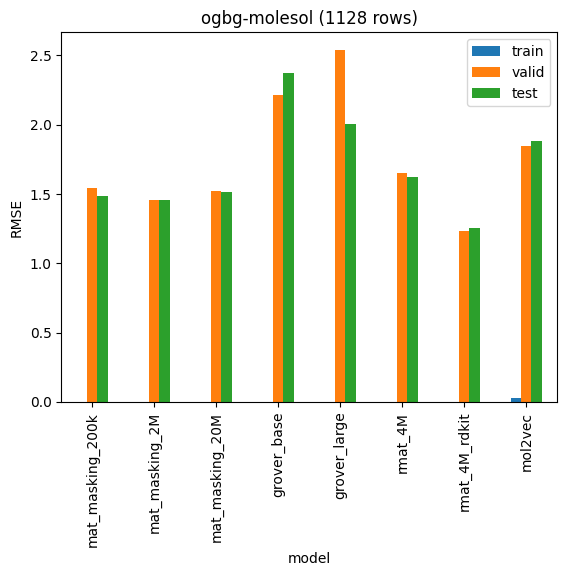

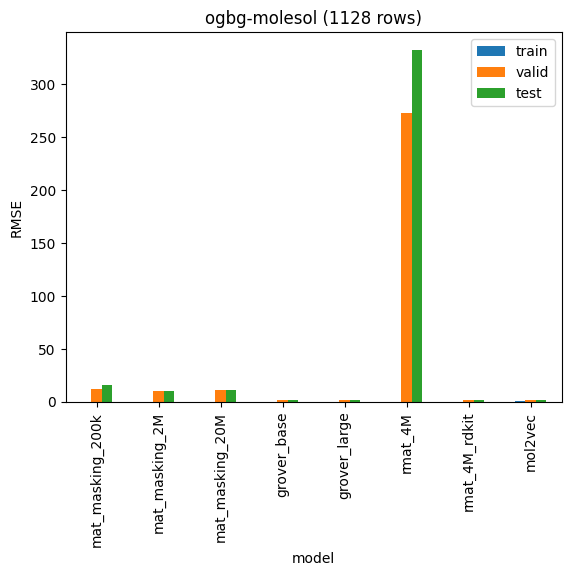

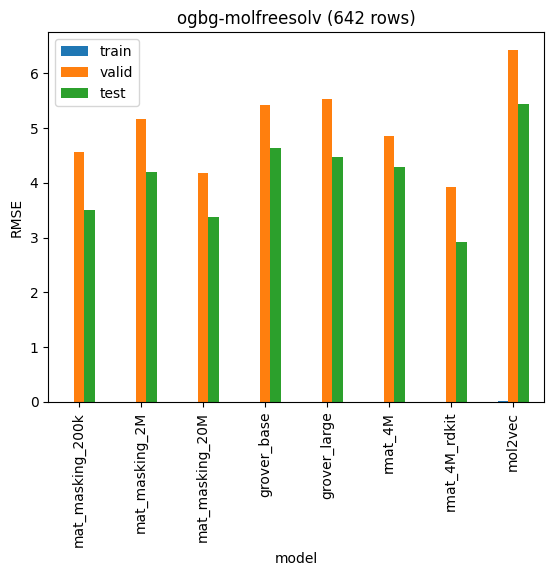

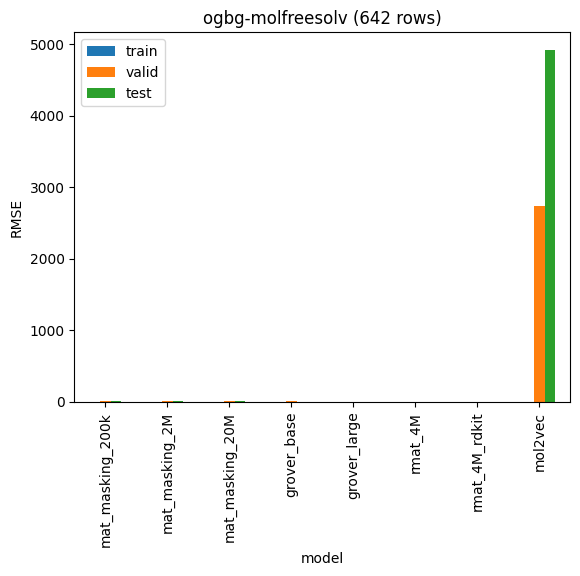

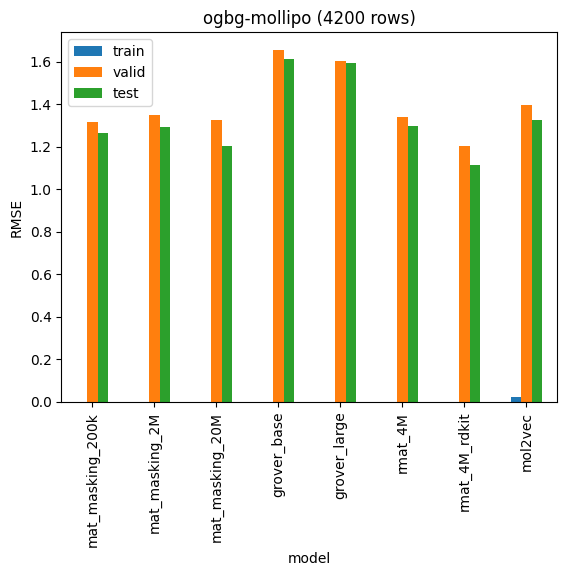

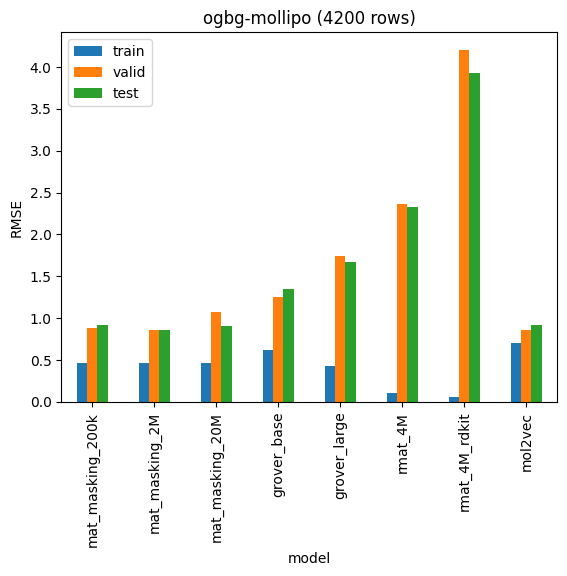

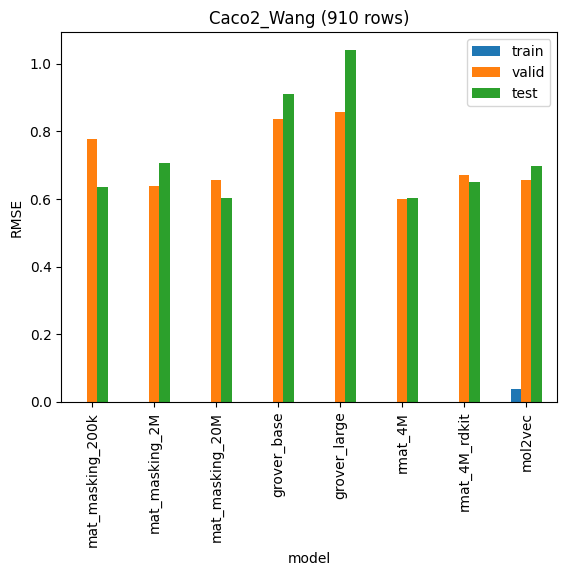

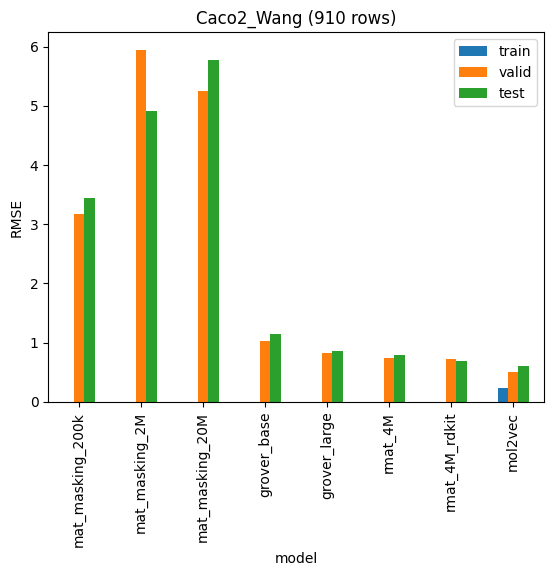

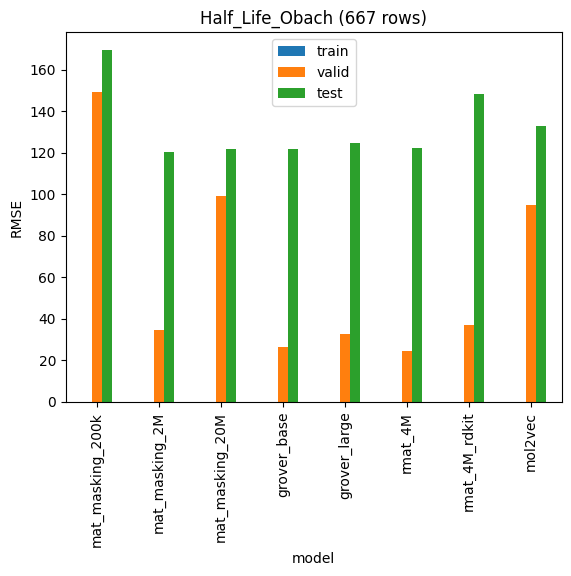

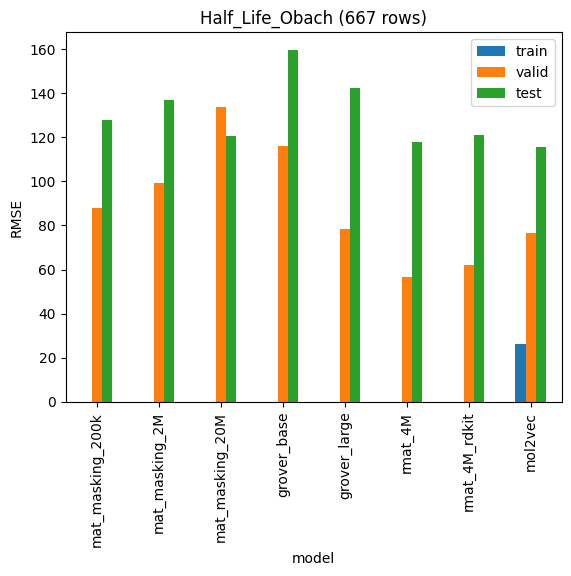

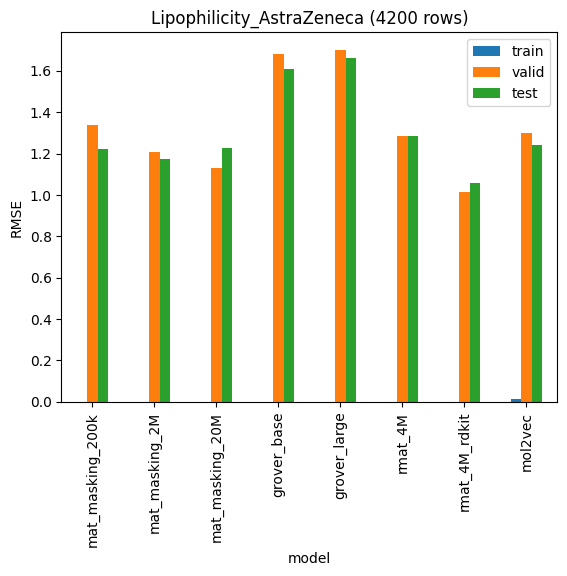

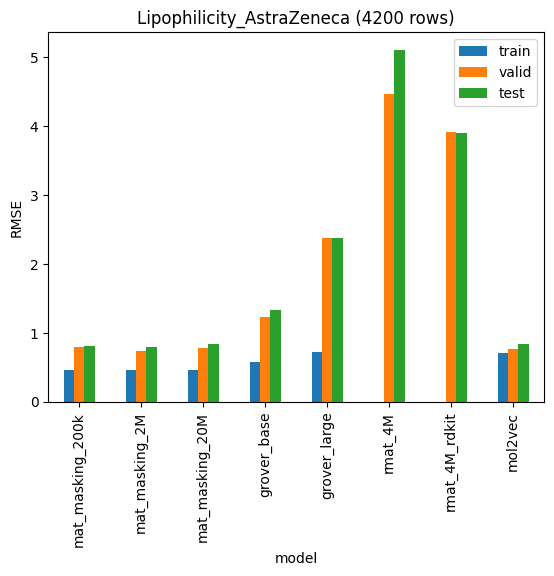

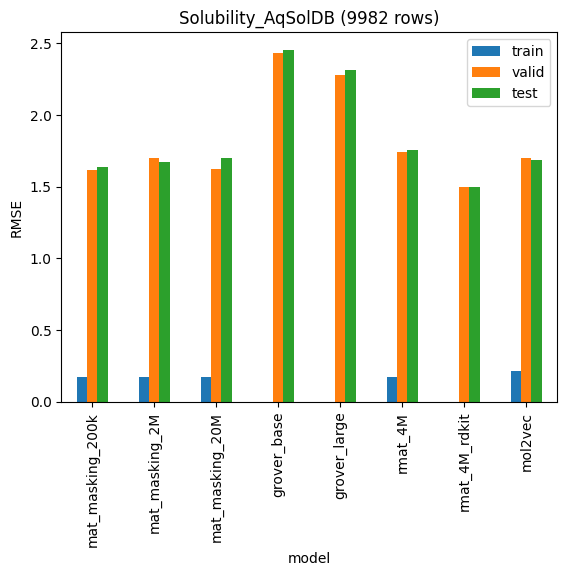

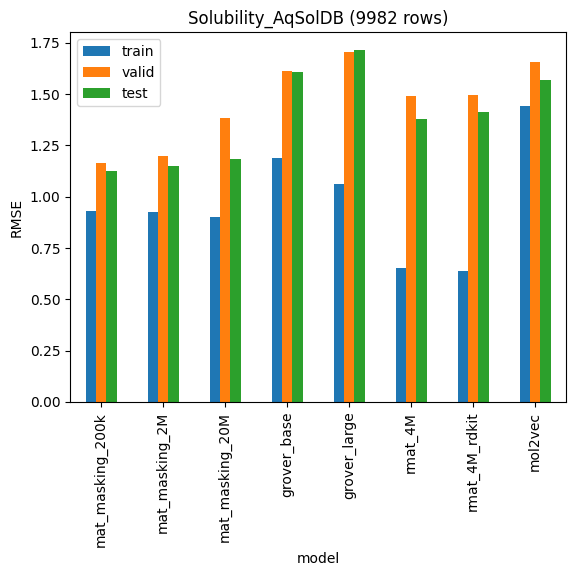

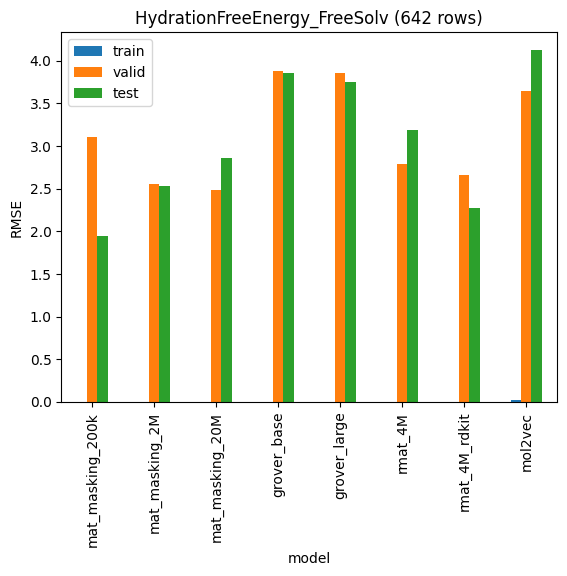

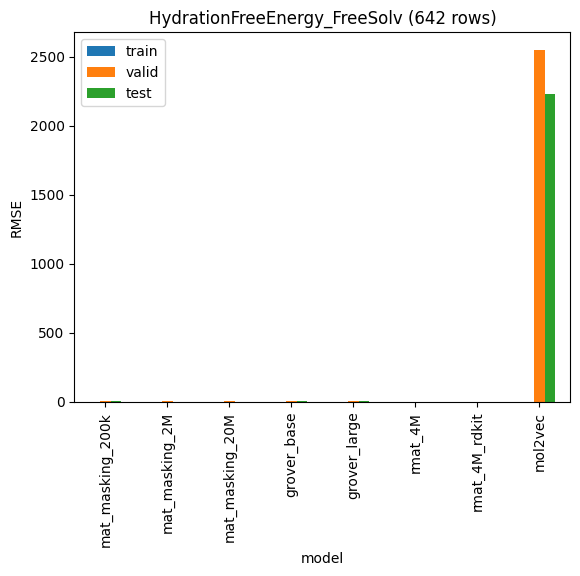

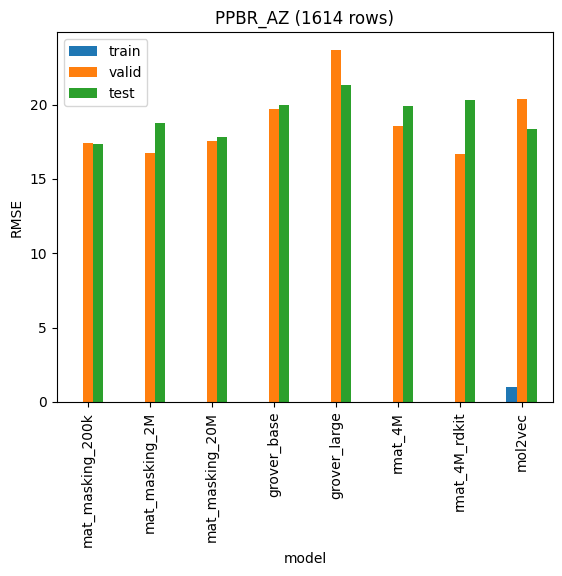

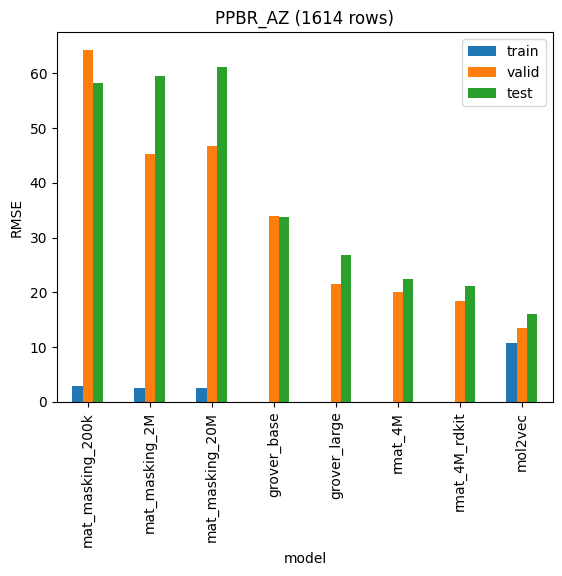

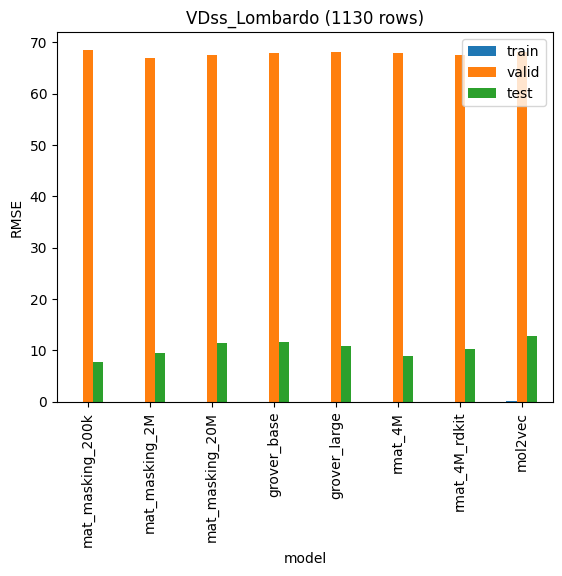

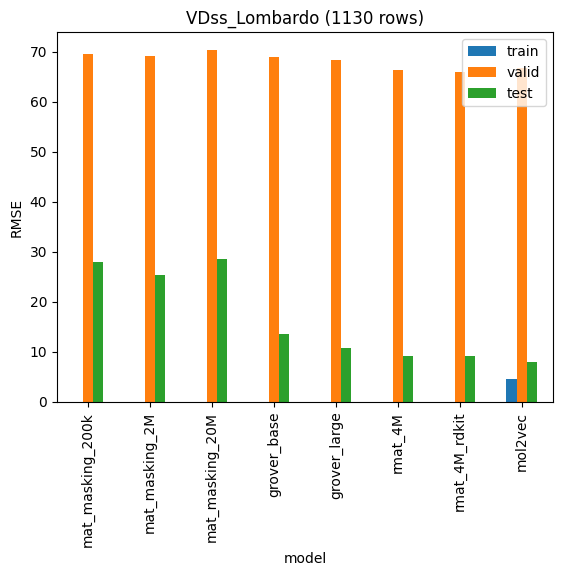

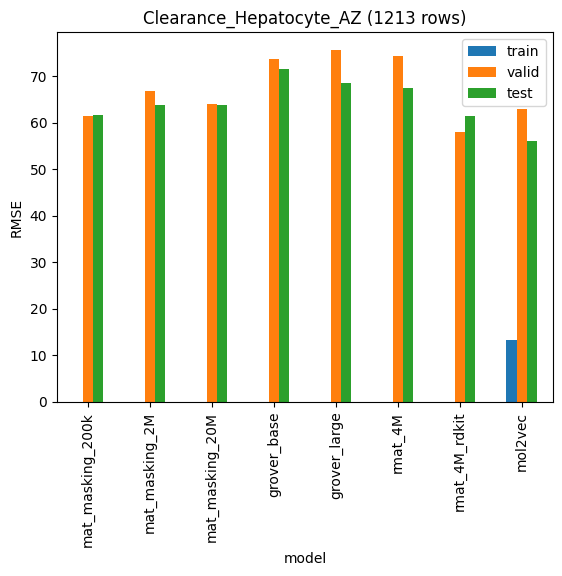

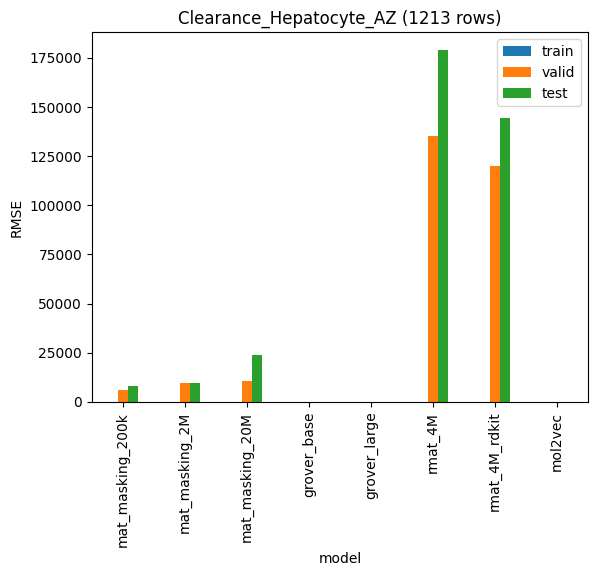

In [10]:
write_to_file(f"# Regression")

with shelve.open('results.db') as db:
    for dataset_name in OGB_regression_datasets + TDC_regression_datasets:
        
        res_tree = db.get(f"{dataset_name}_tree_res", None)
        res_lin = db.get(f"{dataset_name}_lin_res", None)
        
        if res_tree is not None and res_lin is not None:
        
            try:    
                dataset, _ = get_dataset(dataset_name)
                rows_count = len(dataset)
                
                write_to_file(f"## {dataset_name} ({rows_count} rows)")
                
                write_to_file(f"### Decision Tree regression")
                write_to_file(res_tree.to_markdown())
                res_tree[["train", "valid", "test"]].plot.bar(ylim=(0, None), title=f"{dataset_name} ({rows_count} rows)", ylabel="RMSE", xlabel="model")
                plt.savefig(f"plots/{dataset_name}_res_tree.png", bbox_inches="tight")
                write_to_file(f"![plot](plots/{dataset_name}_res_tree.png)")
                
                write_to_file(f"### Linear regression")
                write_to_file(res_lin.to_markdown())
                res_lin[["train", "valid", "test"]].plot.bar(ylim=(0, None), title=f"{dataset_name} ({rows_count} rows)", ylabel="RMSE", xlabel="model")
                plt.savefig(f"plots/{dataset_name}_res_lin.png", bbox_inches="tight")
                write_to_file(f"![plot](plots/{dataset_name}_res_lin.png)")
            except Exception as e:
                write_to_file(f"*Problem with data*")
                write_to_file(str(e))
        else:
            write_to_file(f"## {dataset_name}")
            write_to_file(f"*Data not found*")

Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!


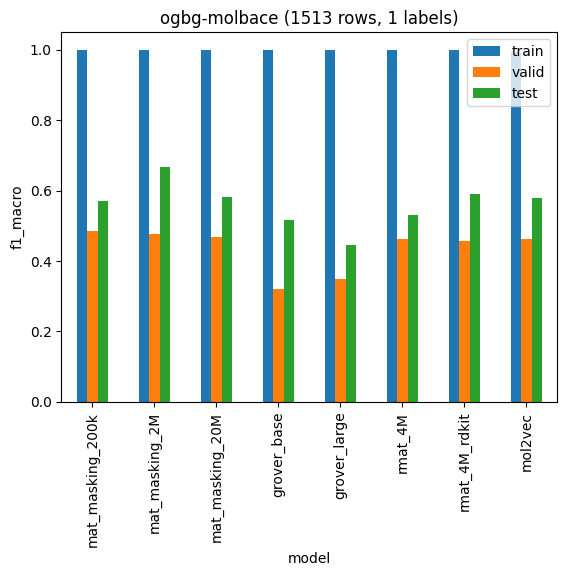

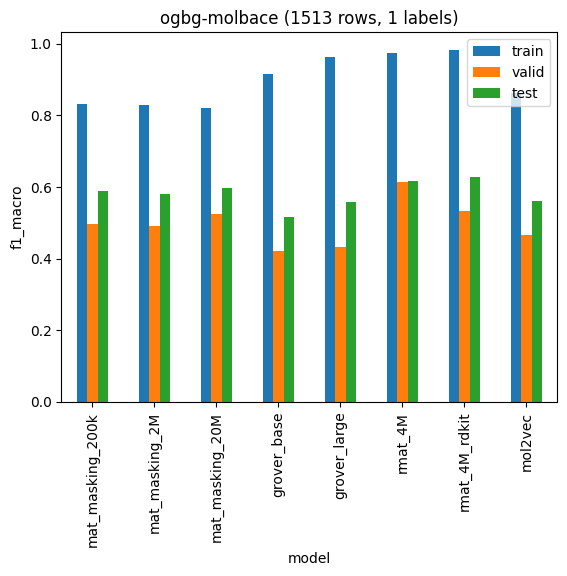

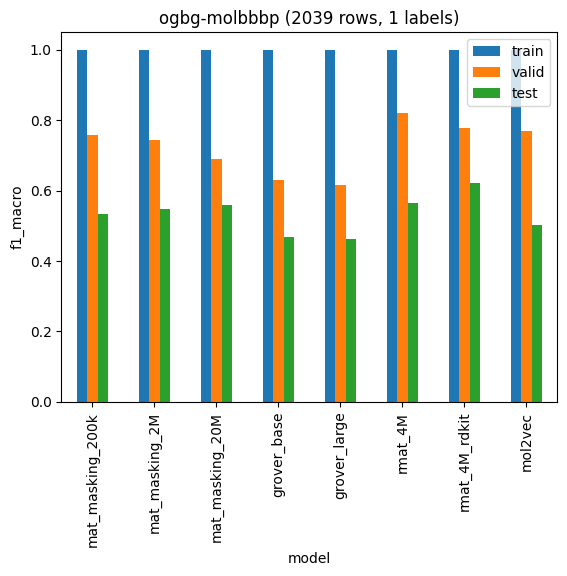

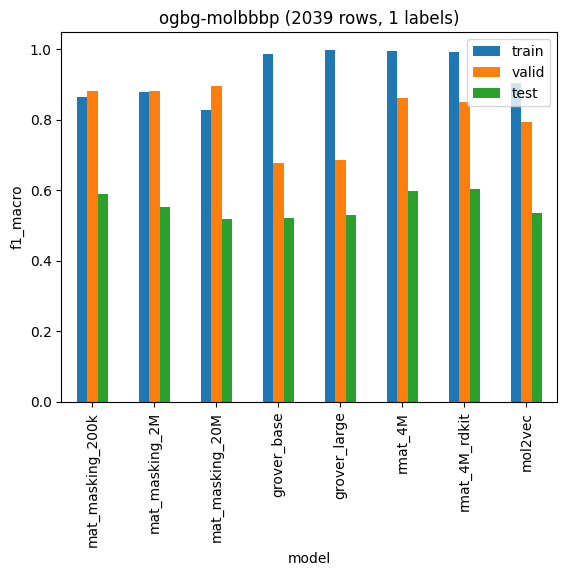

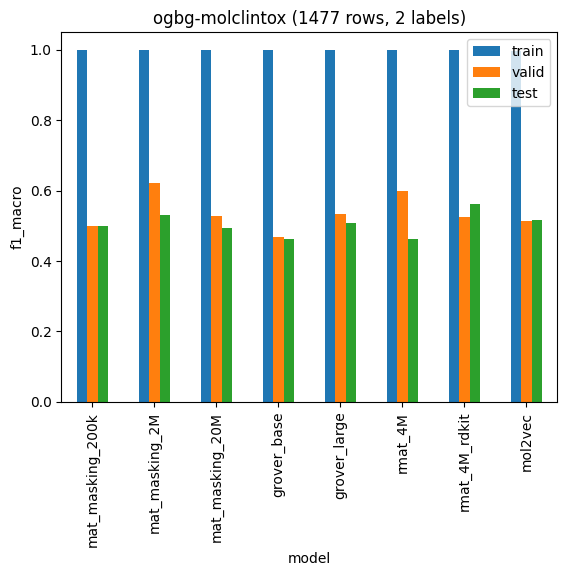

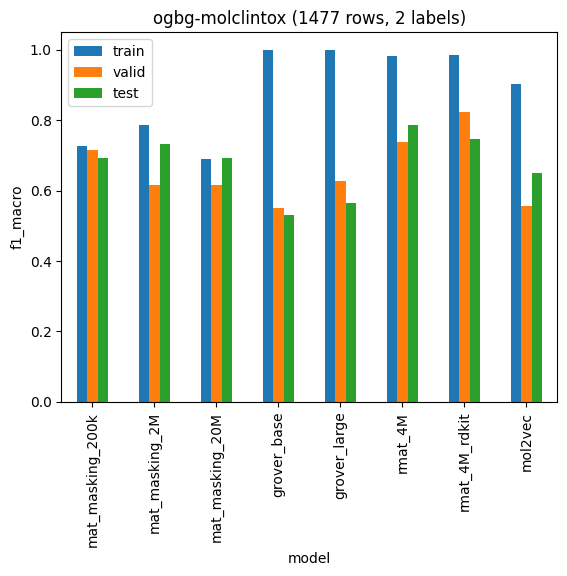

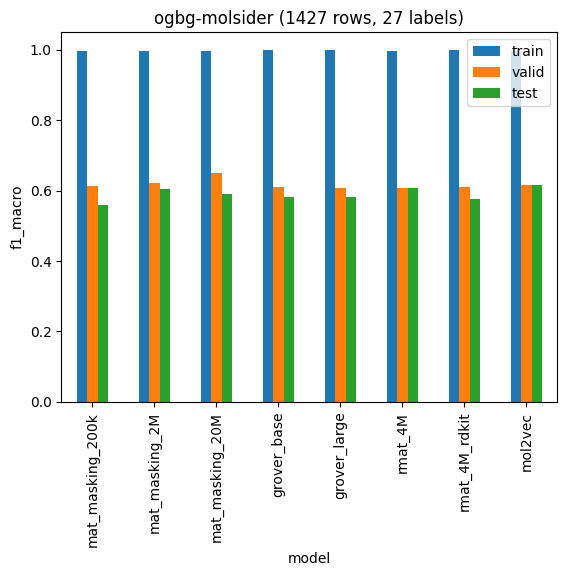

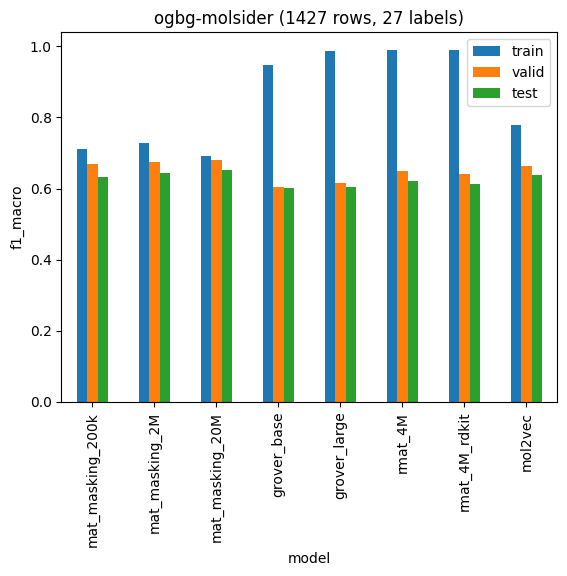

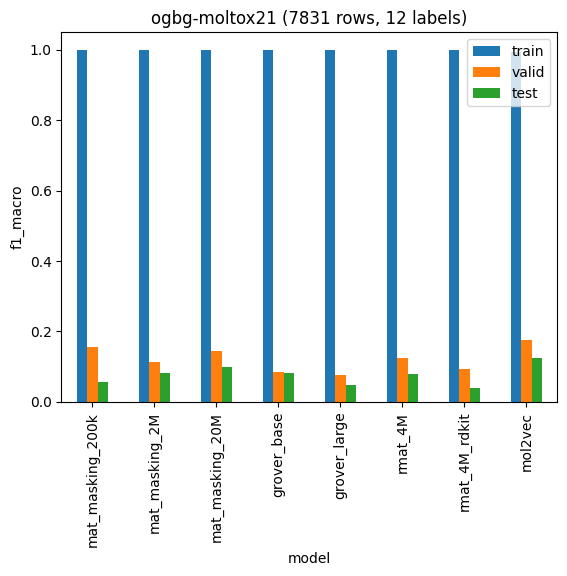

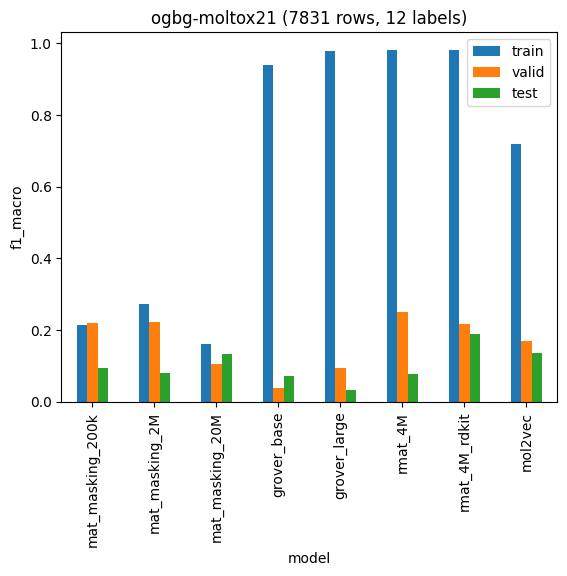

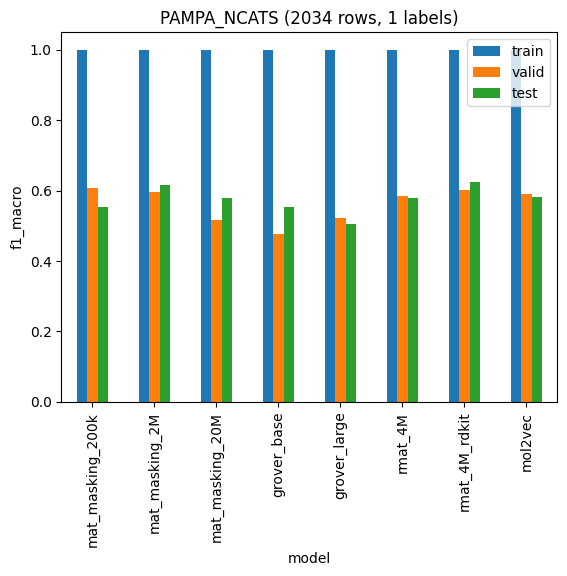

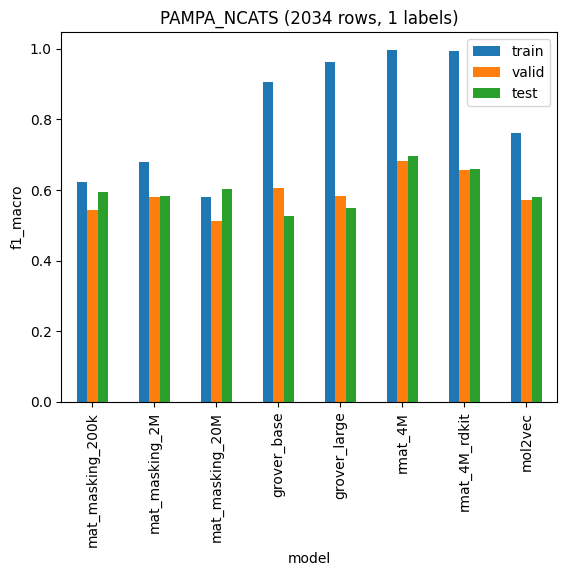

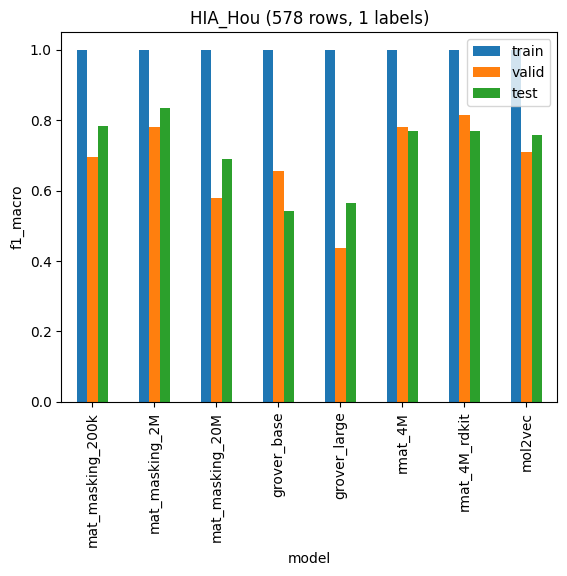

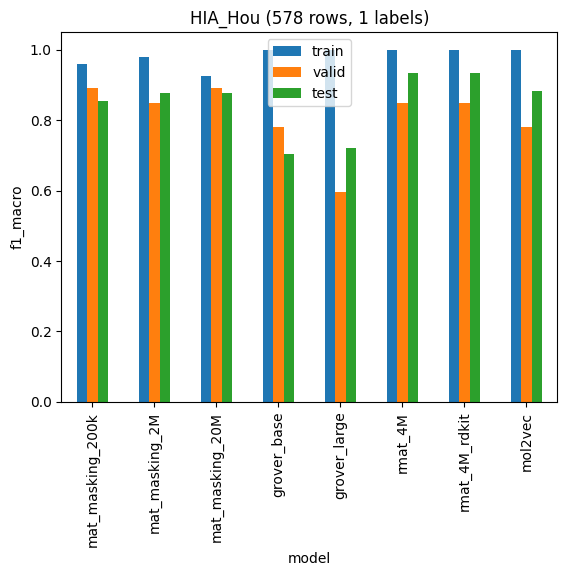

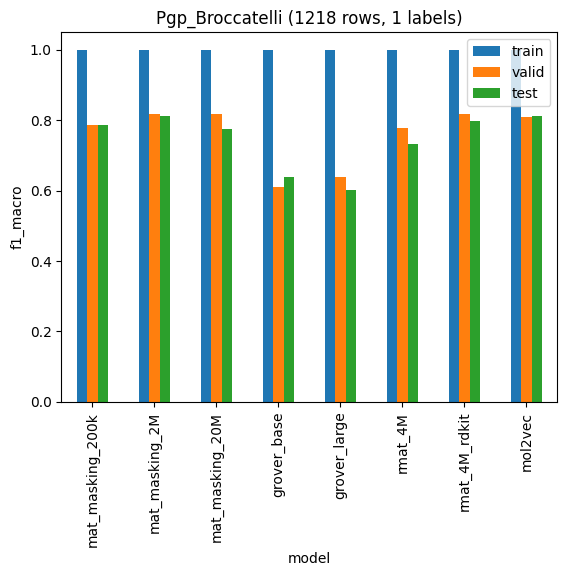

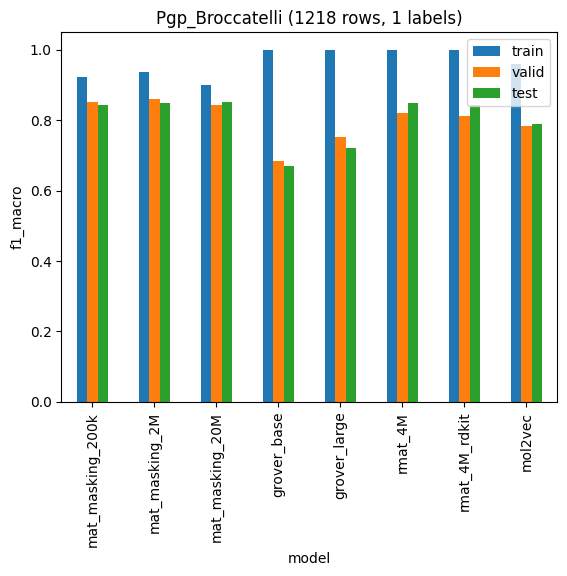

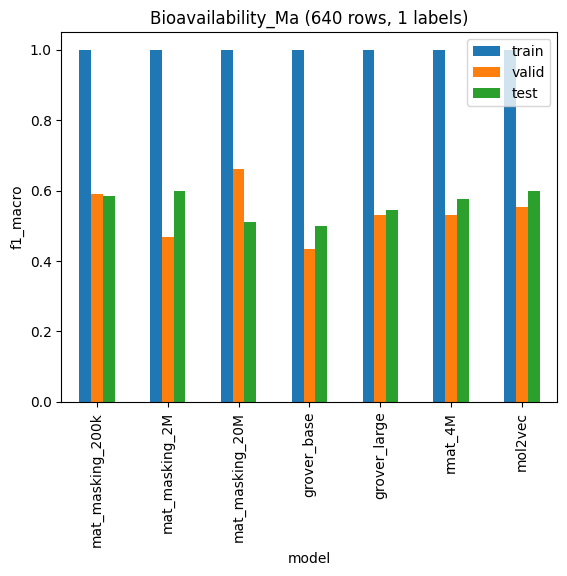

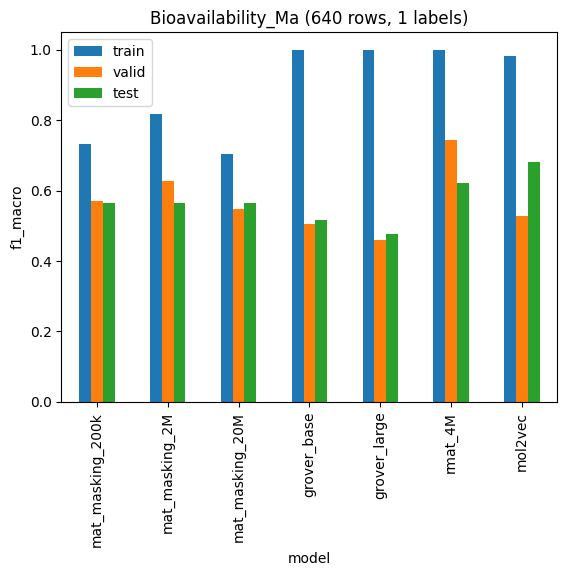

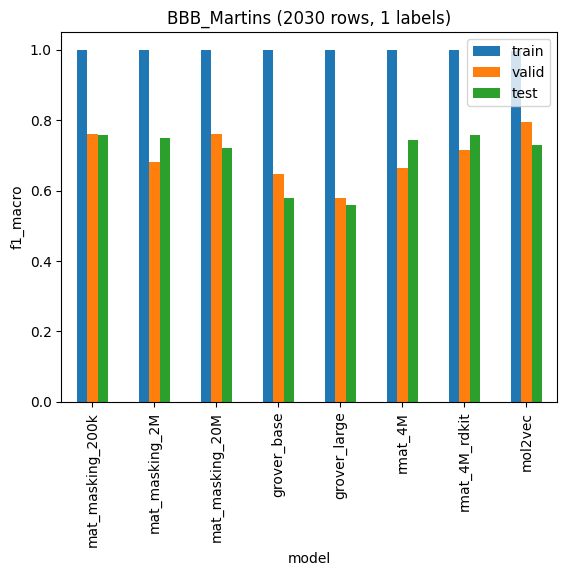

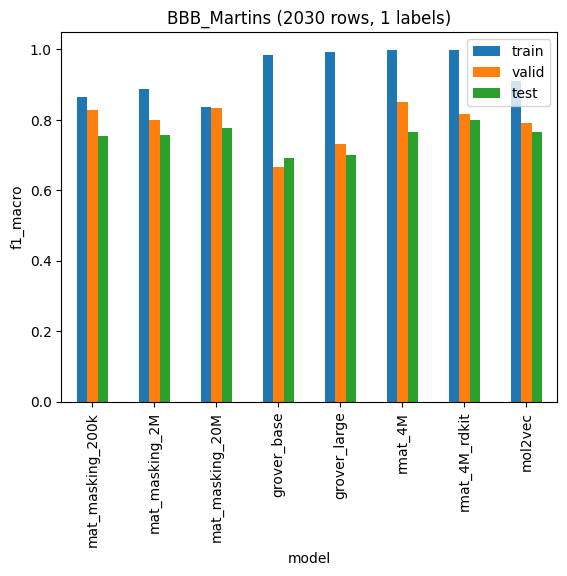

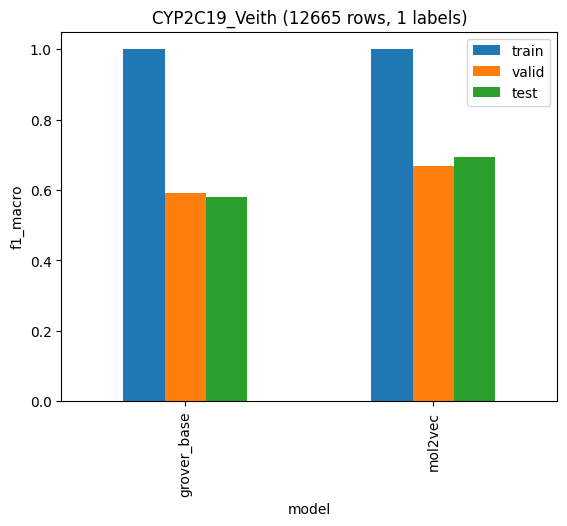

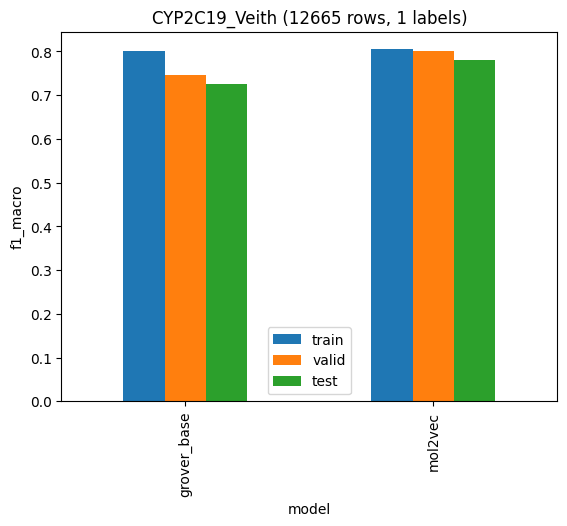

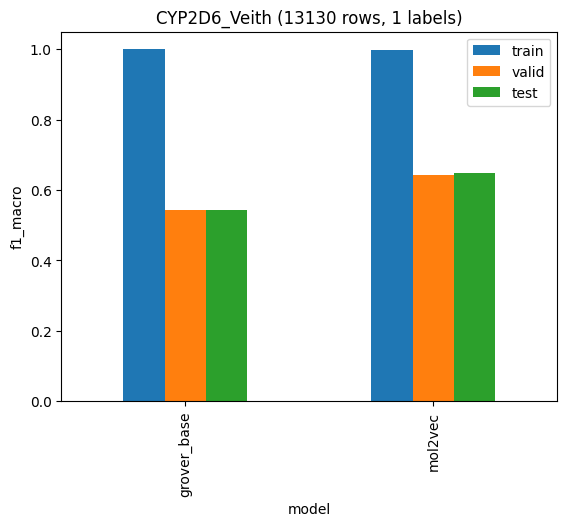

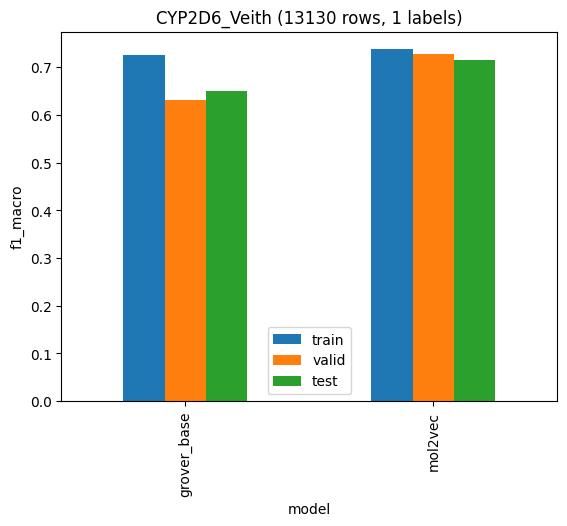

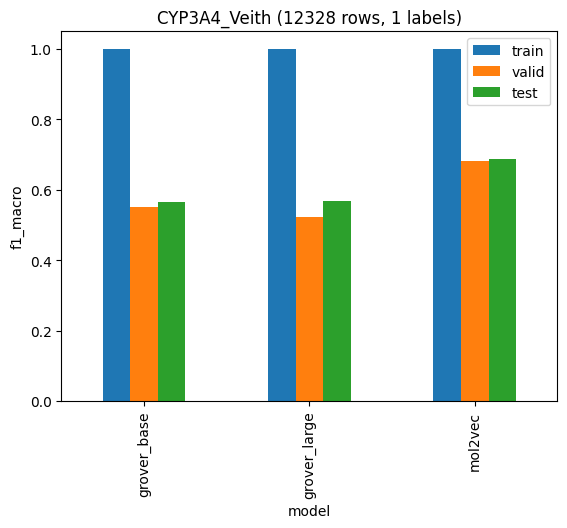

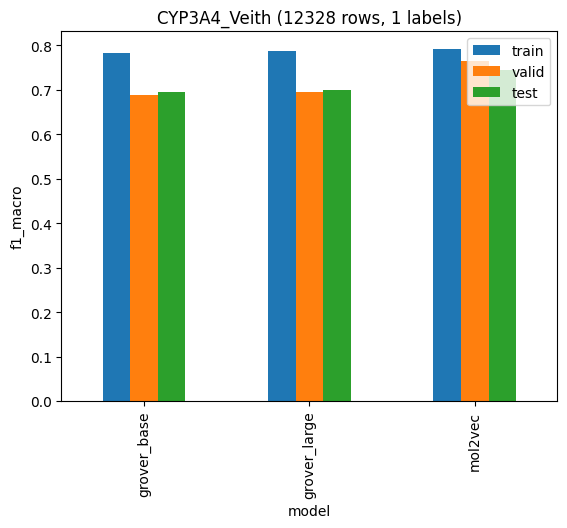

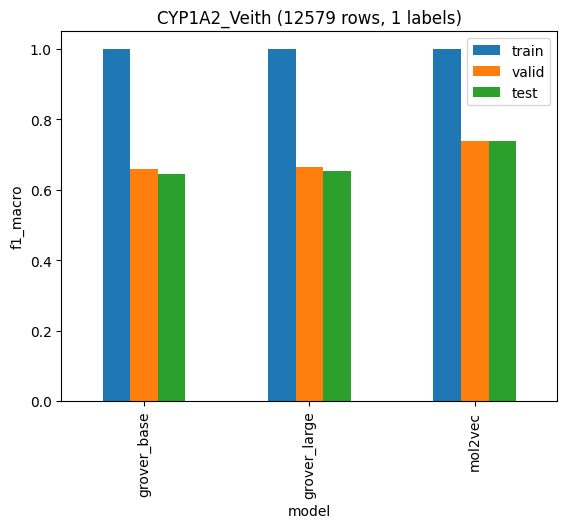

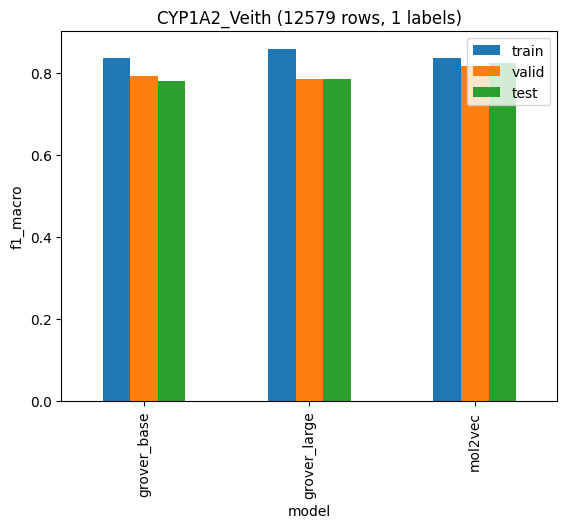

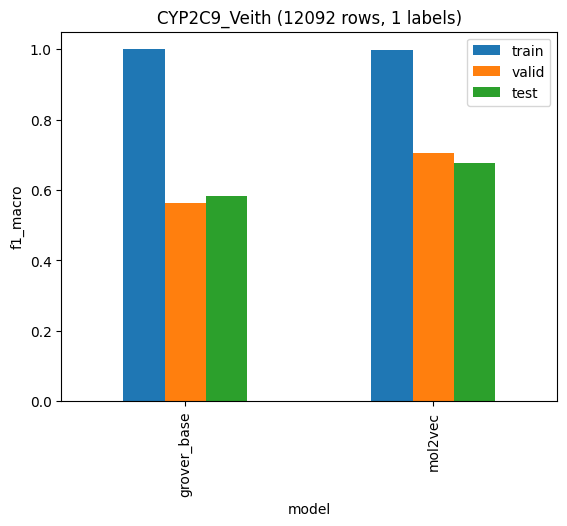

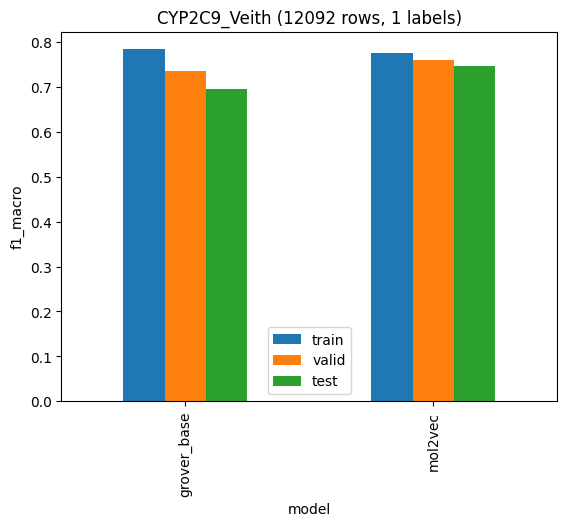

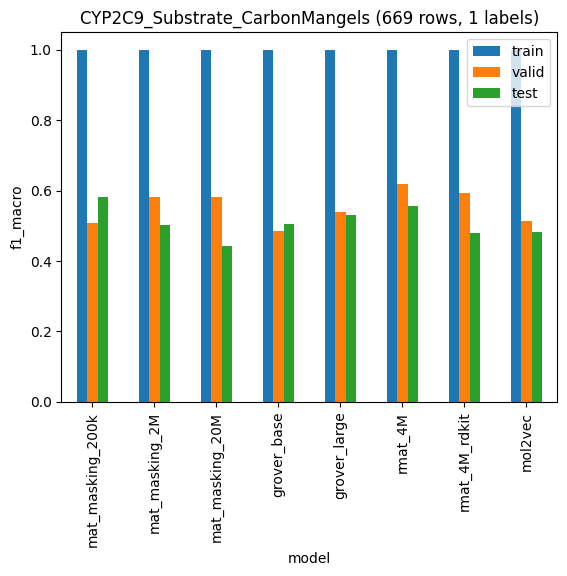

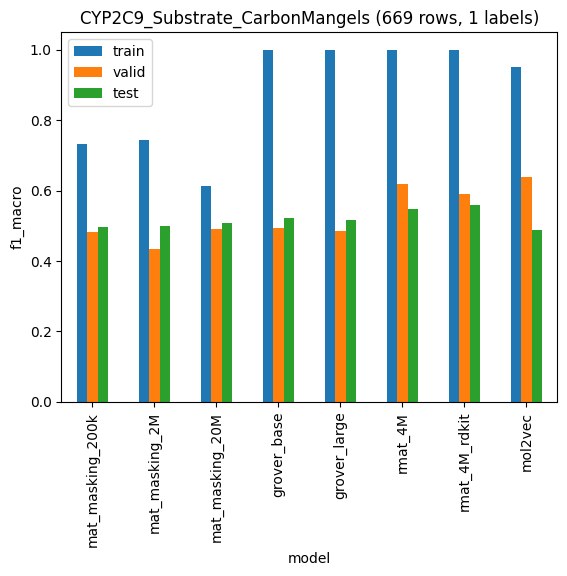

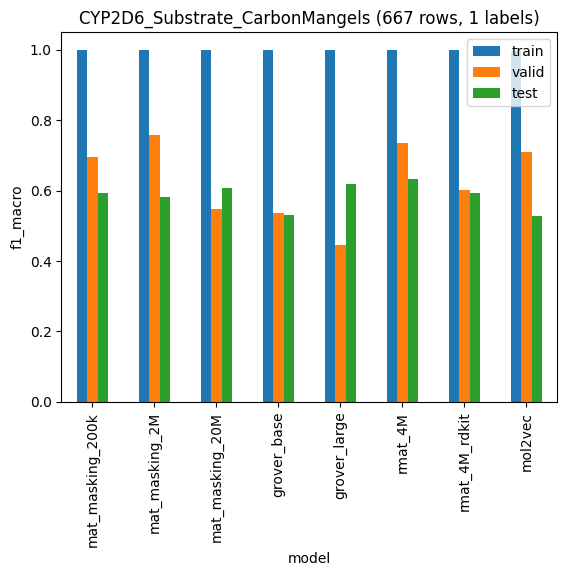

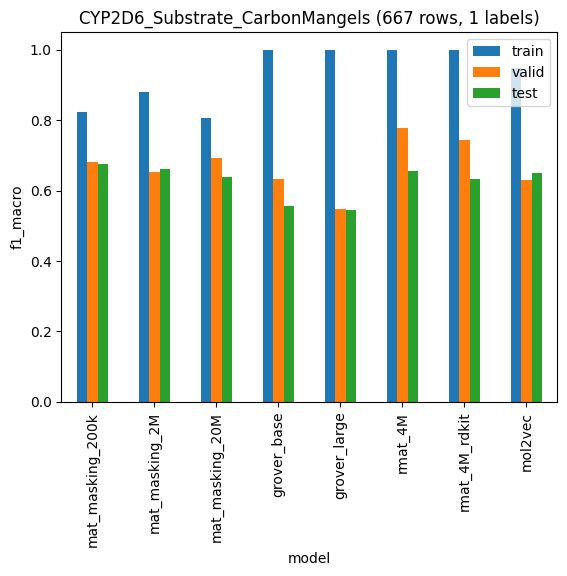

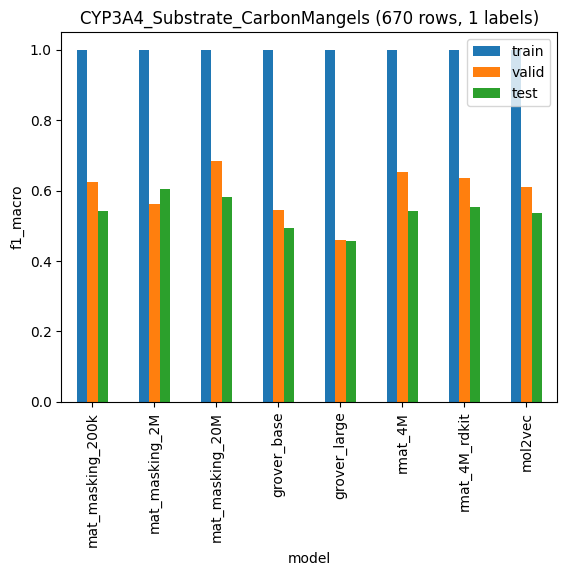

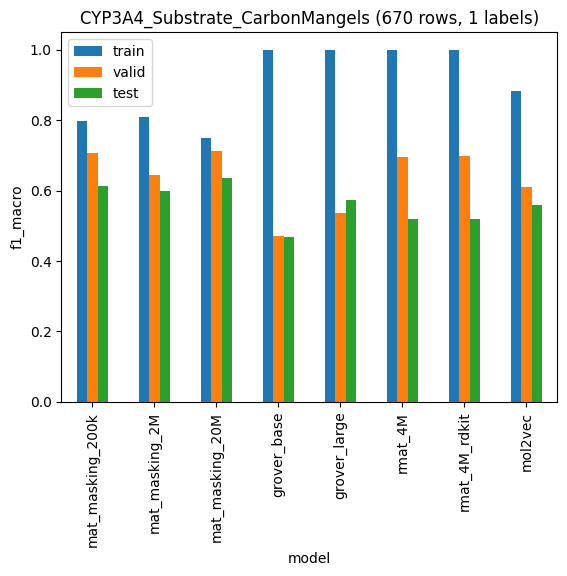

In [12]:
write_to_file(f"# Multi-label classification")

with shelve.open('results.db') as db:
    for dataset_name in OGB_classification_datasets + TDC_classification_datasets:
        
        res_tree = db.get(f"{dataset_name}_tree_res", None)
        res_lin = db.get(f"{dataset_name}_lin_res", None)
        
        if res_tree is not None and res_lin is not None:
        
            try:    
                dataset, _ = get_dataset(dataset_name)
                labels_count = len(list(filter(lambda col: col not in ['smiles', "features", 'embeddings'], dataset.columns)))
                rows_count = len(dataset)
                
                write_to_file(f"## {dataset_name} ({rows_count} rows, {labels_count} labels)")
                
                write_to_file(f"### Decision Tree classification")
                write_to_file(res_tree.to_markdown())
                res_tree[["train", "valid", "test"]].plot.bar(ylim=(0, None), title=f"{dataset_name} ({rows_count} rows, {labels_count} labels)", ylabel="f1_macro", xlabel="model")
                plt.savefig(f"plots/{dataset_name}_res_tree.png", bbox_inches="tight")
                write_to_file(f"![plot](plots/{dataset_name}_res_tree.png)")
                
                write_to_file(f"### Linear classification")
                write_to_file(res_lin.to_markdown())
                res_lin[["train", "valid", "test"]].plot.bar(ylim=(0, None), title=f"{dataset_name} ({rows_count} rows, {labels_count} labels)", ylabel="f1_macro", xlabel="model")
                plt.savefig(f"plots/{dataset_name}_res_lin.png", bbox_inches="tight")
                write_to_file(f"![plot](plots/{dataset_name}_res_lin.png)")
            except Exception as e:
                write_to_file(f"*Problem with data*")
                write_to_file(str(e))
        else:
            write_to_file(f"## {dataset_name}")
            write_to_file(f"*Data not found*")

In [38]:
len(pd.DataFrame({"a": [1,2,3,4,None, None]}).dropna())

4